# 05 Feature Selection

This notebook performs a **manual feature selection** to generate a concise “short‐list” of predictors for the final model.  
It’s organized in modular steps and can be easily extended later (e.g. SHAP, greedy addition, AutoML).

---

## 1. Setup & Load Data

- Load the full feature matrix (`train_features_full.csv`) with `SK_ID_CURR` and `TARGET`
- Display the data shape


In [3]:
# Add project root to Python path and import libraries
import sys, os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
import lightgbm as lgb

# Dynamically determine the project root (one level above the notebook folder)
proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)
    
from src.feature_selection_utils import evaluate_auc


# Build path to the full-feature CSV
feat_file = os.path.join(proj_root, "outputs", "train_features_full.csv")

# Load the dataset
df = pd.read_csv(feat_file)
print(f"Dataset shape: {df.shape}")

Dataset shape: (307511, 198)


## 2. Basic Filtering: Missingness & Low Variance (numeric features only)

- Replace infinite values with NaN  
- Drop numeric features with **>80% missing values**  
- Drop numeric features that are **constant** or have **near-zero variance**  
- Keep categorical features for later encoding and selection


In [4]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold

# Identify all feature columns (excluding ID and target)
feature_cols = [c for c in df.columns if c not in ["SK_ID_CURR", "TARGET"]]

# Split into numeric vs. non-numeric
numeric_feats = df[feature_cols].select_dtypes(include="number").columns.tolist()
categorical_feats = [c for c in feature_cols if c not in numeric_feats]
print(f"{len(numeric_feats)} numeric features, {len(categorical_feats)} non-numeric features")

# Replace infinite values with NaN (to avoid errors)
df[numeric_feats] = df[numeric_feats].replace([np.inf, -np.inf], np.nan)

# Drop numeric features with high missing rate (>80%)
missing_threshold = 0.8
missing_rate = df[numeric_feats].isna().mean()
to_drop_missing = missing_rate[missing_rate > missing_threshold].index.tolist()

# Drop numeric features with near-zero variance
vt = VarianceThreshold(threshold=1e-5)
vt.fit(df[numeric_feats].fillna(0))
to_drop_low_var = [
    feat for feat, keep in zip(numeric_feats, vt.get_support()) if not keep
]

# Combine and drop from dataframe
to_drop = set(to_drop_missing + to_drop_low_var)
print(f"Dropping {len(to_drop)} numeric features (missing or low variance)")

selected_numeric = [feat for feat in numeric_feats if feat not in to_drop]
df = df[["SK_ID_CURR"] + selected_numeric + ["TARGET"]]
print("New shape after numeric filtering:", df.shape)


176 numeric features, 20 non-numeric features
Dropping 4 numeric features (missing or low variance)
New shape after numeric filtering: (307511, 174)


## 3. Baseline Model: LightGBM with Default Parameters

- Define a quick stratified CV setup
- Compute baseline AUC to serve as a reference, imbalanced yet


In [5]:
# prepare X and y
X = df.drop(columns=["SK_ID_CURR", "TARGET"])
y = df["TARGET"]

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = lgb.LGBMClassifier(random_state=42)

# baseline AUC
evaluate_auc(X, y, model, cv, name="Baseline")

[Baseline] AUC: 0.7788 ± 0.0042


(0.7787736421386565, 0.004189895117424911)

## 4. Model-Based Importance Filtering (Elbow Method)

- Train LightGBM on the full data  
- Extract `feature_importances_` (gain)  
- Compute cumulative importance and locate the “elbow”  
- Remove all features beyond the elbow


In [6]:
# a) Train on the full dataset
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)

# b) Sort and compute cumulative sum
imp_sorted = importances.sort_values(ascending=False)
cum_imp = imp_sorted.cumsum() / imp_sorted.sum()

# c) Find the elbow point
from kneed import KneeLocator
kl = KneeLocator(
    x=range(len(cum_imp)),
    y=cum_imp.values,
    curve="concave",
    direction="increasing"
)
cutoff = kl.knee
print(f"Elbow at rank {cutoff}, corresponding to {cum_imp.values[cutoff]:.2%} cumulative importance")

# d) Keep features up to the elbow
selected_feats = imp_sorted.index[:cutoff + 1].tolist()
X_imp = X[selected_feats]
print("Shape after elbow filter:", X_imp.shape)

# e) Evaluate performance
evaluate_auc(X_imp, y, model, cv, name="After Elbow Importance Filter")

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24643
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 170
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
Elbow at rank 55, corresponding to 84.00% cumulative importance
Shape after elbow filter: (307511, 56)
[After Elbow Importance Filter] AUC: 0.7786 ± 0.0036


(0.7786272725504639, 0.0036481544560647856)

**Key Takeaway:** Using the elbow method, we reduced the feature set to 56 variables (capturing 84 % of total gain) while retaining an AUC of 0.7786 ± 0.0036, demonstrating a strong trade-off between simplicity and performance.


## 5. Correlation Filtering

- Compute absolute pairwise correlations on the filtered feature set  
- For each pair with |corr| > 0.90, drop the feature with lower model importance  
- Re-evaluate AUC on the de-correlated feature set  


In [7]:
# Compute absolute correlation matrix
corr_matrix = X_imp.corr().abs()

# Select upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify features to drop and record their correlation values
drop_info = []
threshold = 0.90
for col in upper.columns:
    for other in upper.index[upper[col] > threshold]:
        corr_val = upper.at[other, col]
        # drop the one with lower importance
        if importances[col] < importances[other]:
            drop_info.append((col, other, corr_val))
        else:
            drop_info.append((other, col, corr_val))

to_drop = list({feat for feat, _, _ in drop_info})

# Print detailed drop list
print("Dropping the following highly correlated features:")
for feat, corr_with, corr_val in drop_info:
    print(f"- {feat} (corr={corr_val:.2f}) with {corr_with}")

# Drop and form final matrix
X_corr = X_imp.drop(columns=to_drop)
print(f"New shape after correlation filter: {X_corr.shape}")

# Evaluate performance after correlation filtering
evaluate_auc(X_corr, y, model, cv, name="After Correlation Filter")


Dropping the following highly correlated features:
- YEARS_EMPLOYED (corr=1.00) with DAYS_EMPLOYED
- AGE (corr=1.00) with DAYS_BIRTH
- AGE_EMPLOYED_PRODUCT (corr=0.97) with DAYS_EMPLOYED
- AGE_EMPLOYED_PRODUCT (corr=0.97) with YEARS_EMPLOYED
- AMT_CREDIT (corr=0.99) with AMT_GOODS_PRICE
- pc_CNT_INSTALMENT_MEAN (corr=0.95) with pc_CNT_INSTALMENT_FUTURE_MEAN
New shape after correlation filter: (307511, 51)
[After Correlation Filter] AUC: 0.7785 ± 0.0042


(0.7785260658971372, 0.004168741604691038)

## 6. SHAP-Based Feature Elimination

- Compute SHAP values on a held-out test set to estimate feature importance  
- Rank features by mean absolute SHAP value and plot them to see which are the most important
- Iteratively drop the least important features (1 to 20)  
- Re-evaluate AUC after each drop using 5-fold cross-validation  


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10890
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


c:\Users\timgr_\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


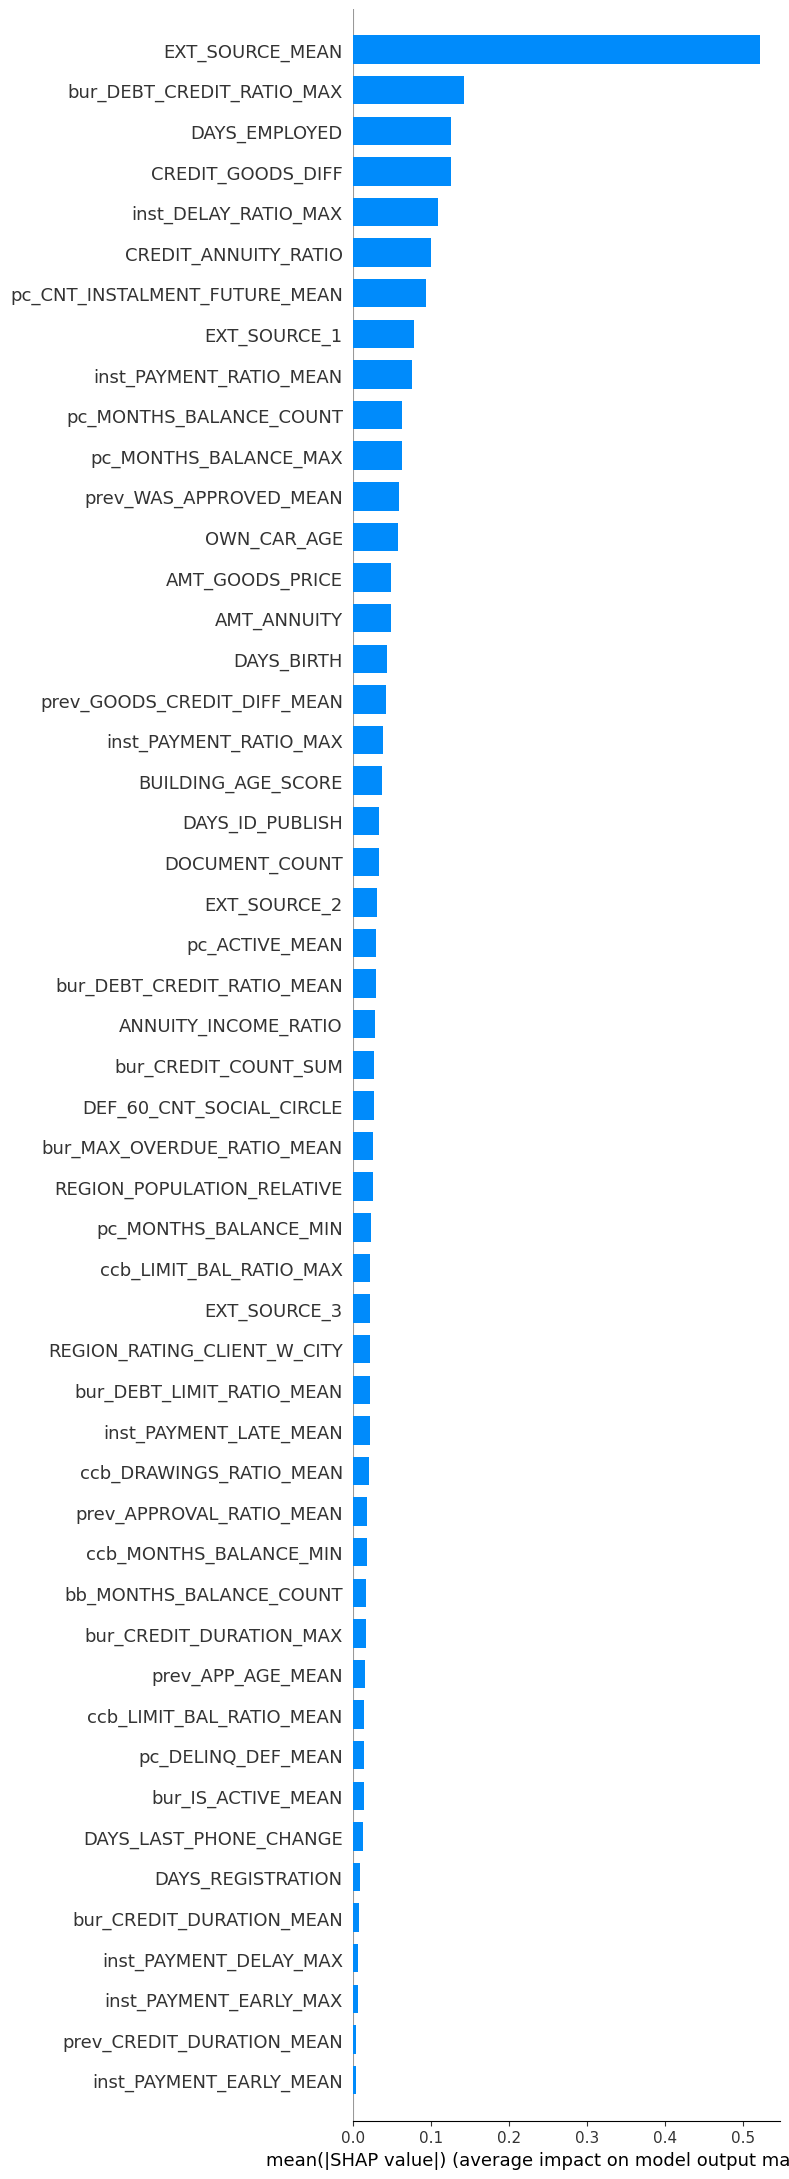

Iterative SHAP Feature Elimination (CV-AUC):
n_dropped | AUC        | STD       | Dropped Features
-----------------------------------------------------------
1         | 0.77882 | 0.00388 | inst_PAYMENT_EARLY_MEAN
2         | 0.77875 | 0.00382 | inst_PAYMENT_EARLY_MEAN, prev_CREDIT_DURATION_MEAN
3         | 0.77838 | 0.00388 | inst_PAYMENT_EARLY_MEAN, prev_CREDIT_DURATION_MEAN, inst_PAYMENT_EARLY_MAX
4         | 0.77876 | 0.00391 | inst_PAYMENT_EARLY_MEAN, prev_CREDIT_DURATION_MEAN, inst_PAYMENT_EARLY_MAX, inst_PAYMENT_DELAY_MAX
5         | 0.77846 | 0.00371 | inst_PAYMENT_EARLY_MEAN, prev_CREDIT_DURATION_MEAN, inst_PAYMENT_EARLY_MAX, inst_PAYMENT_DELAY_MAX, bur_CREDIT_DURATION_MEAN
6         | 0.77856 | 0.00394 | inst_PAYMENT_EARLY_MEAN, prev_CREDIT_DURATION_MEAN, inst_PAYMENT_EARLY_MAX, inst_PAYMENT_DELAY_MAX, bur_CREDIT_DURATION_MEAN, DAYS_REGISTRATION
7         | 0.77854 | 0.00410 | inst_PAYMENT_EARLY_MEAN, prev_CREDIT_DURATION_MEAN, inst_PAYMENT_EARLY_MAX, inst_PAYMENT_DELAY_MAX,

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold

# === Prepare data ===
X = X_corr.copy()
y = df['TARGET']

# Train/test split for SHAP value computation only (not for evaluation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Train model and compute SHAP values ===
def compute_shap_values(model, X_background, X_target):
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_target)
    return shap_vals[1] if isinstance(shap_vals, list) else shap_vals

model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

shap_values = compute_shap_values(model, X_train, X_test)

# SHAP summary plot (bar plot of mean absolute SHAP values)
shap.summary_plot(
    shap_values, X_test,
    plot_type="bar",
    max_display=shap_values.shape[1]
)

# === Iterative SHAP-based feature elimination with CV-AUC evaluation ===
def iteratively_drop_least_important_features(X, y, shap_vals, max_drop=20):
    # Compute mean absolute SHAP value per feature
    mean_shap = np.abs(shap_vals).mean(axis=0)
    feature_ranking = pd.Series(mean_shap, index=X.columns).sort_values()

    model = lgb.LGBMClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("Iterative SHAP Feature Elimination (CV-AUC):")
    print("n_dropped | AUC      | STD     | Dropped Features")
    print("--------------------------------------------------------------")

    for n in range(1, max_drop + 1):
        to_drop = feature_ranking.index[:n].tolist()
        X_reduced = X.drop(columns=to_drop)
        mean_auc, std_auc = evaluate_auc(X_reduced, y, model, cv, verbose=False)
        print(f"{n:<9} | {mean_auc:.5f} | {std_auc:.5f} | {', '.join(to_drop)}")

# Run elimination for up to 20 least important features
iteratively_drop_least_important_features(X, y, shap_values, max_drop=20)


### Final Feature Selection Decision

Based on the SHAP-based feature elimination with cross-validated AUC, it was observed that dropping the 13 least important features slightly reduced model complexity while slightly increasing  performance (AUC = 0.77883 ± 0.00388).

Therefore, **the following 13 features** will be **removed** from the final feature set:

`inst_PAYMENT_EARLY_MEAN`, `prev_CREDIT_DURATION_MEAN`, `inst_PAYMENT_EARLY_MAX`, `inst_PAYMENT_DELAY_MAX`, `bur_CREDIT_DURATION_MEAN`, `DAYS_REGISTRATION`, `DAYS_LAST_PHONE_CHANGE`, `bur_IS_ACTIVE_MEAN`, `pc_DELINQ_DEF_MEAN`, `ccb_LIMIT_BAL_RATIO_MEAN`, `prev_APP_AGE_MEAN`, `bur_CREDIT_DURATION_MAX`, `bb_MONTHS_BALANCE_COUNT`

Notably, `EXT_SOURCE_MEAN` was identified as the most important feature by SHAP. Since this variable has around 20% missing values, it might be valuable to train a separate model to impute or predict `EXT_SOURCE_MEAN` based on the available features.

## 6. Export Selected Features

- Save the manually selected feature names for tracking
- Ready for the next steps: hyperparameter tuning, ensembling, automated search


In [ ]:
import os
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

# Final features to drop
final_drops = [
    "inst_PAYMENT_EARLY_MEAN", "prev_CREDIT_DURATION_MEAN", "inst_PAYMENT_EARLY_MAX",
    "inst_PAYMENT_DELAY_MAX", "bur_CREDIT_DURATION_MEAN", "DAYS_REGISTRATION",
    "DAYS_LAST_PHONE_CHANGE", "bur_IS_ACTIVE_MEAN", "pc_DELINQ_DEF_MEAN",
    "ccb_LIMIT_BAL_RATIO_MEAN", "prev_APP_AGE_MEAN", "bur_CREDIT_DURATION_MAX",
    "bb_MONTHS_BALANCE_COUNT"
]

# Create reduced feature set
X_final = X.drop(columns=final_drops)
y_final = y

# CV evaluation
evaluate_auc(X_final, y_final, model, cv, name="Final Reduced Model")

# Add ID and target for export
df_final = pd.concat([df[["SK_ID_CURR", "TARGET"]], X_final], axis=1)

# Export as CSV
output_path = os.path.join(proj_root, "outputs", "01_train_features_first_baseline.csv")
df_final.to_csv(output_path, index=False)
print(f"Final feature set saved to: {output_path}")


[Final Reduced Model] AUC: 0.7788 ± 0.0039
Final feature set saved to: c:\Users\timgr_\OneDrive\Desktop\Master_Studium\3. Semester\Home_Credit_Projekt\Home_Credit_Project\outputs\train_features_final.csv


## 7. Extensions & Next Steps

- **SHAP Analysis**: add a cell here to remove features with consistently negative/low SHAP impact  
- **Greedy Addition**: insert a section for iterative feature‐adding tests  
- **Auto Feature Search**: plan a separate `06_auto_feature_search.ipynb` that uses TPOT or Auto-sklearn on this pruned set  
- **Hyperparameter Tuning**: tune the final model using Optuna or RandomizedSearchCV  
- **Ensembling**: blend multiple tuned models for further gains
